In [1]:
# https://www.mindcoolness.com/blog/blog-post-clustering-nlp/

# 1. Modules & Data

In [2]:
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS, TSNE
import mpld3
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
import tensorflow as tf
from sklearn.metrics import silhouette_score, calinski_harabasz_score
# from sklearn.metrics import calinski_harabasz_score

# load data
data = pd.read_csv('./datasets/200_sent_correct_all.csv', error_bad_lines=False)

C:\Users\xt17aab\AppData\Local\Temp\ipykernel_15256\533894813.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv('./datasets/200_sent_correct_all.csv', error_bad_lines=False)


In [3]:
data.tail()

,No.,mongodb_id,content,recommend,sent_tokens,preprocessed_reviews_nm,correct,sent_id
901,62085,5f79a2c00abf462594a36ecc,"\n\t\t\t\t\t\t\t\t""NO MANS LIE"" This is how i ...",True,They worked and worked - all for free !,"['work', 'work', 'free']","['work', 'work', 'free']",902
902,62085,5f79a2c00abf462594a36ecc,"\n\t\t\t\t\t\t\t\t""NO MANS LIE"" This is how i ...",True,"If you have the game you pay no cent, no servi...","['pay', 'no', 'cent', 'no', 'service', 'no', '...","['pay', 'no', 'cent', 'no', 'service', 'no', '...",903
903,62085,5f79a2c00abf462594a36ecc,"\n\t\t\t\t\t\t\t\t""NO MANS LIE"" This is how i ...",True,Even if you will never play it ( you most defi...,"['even', 'never', 'play', 'definetly', 'buy', ...","['even', 'never', 'play', 'definetly', 'buy', ...",904
904,93450,5f6e3571e9ecc48bee9a3dc1,\n\t\t\t\t\t\t\t\tNo Man's Sky had very many f...,False,\n\t\t\t\t\t\t\t\tNo Man's Sky had very many f...,"['no_man_sky', 'many', 'feature', 'miss', 'pla...","['no_man_sky', 'many', 'feature', 'miss', 'pla...",905
905,33700,5f76d3ac28978d4999d9f27c,\n\t\t\t\t\t\t\t\tLove this game if you like e...,True,\n\t\t\t\t\t\t\t\tLove this game if you like e...,"['love', 'like', 'explore', 'give', 'go']","['love', 'like', 'explore', 'give', 'go']",906


In [4]:
eval(data['correct'][4])

['nice', 'push', 'towards', 'end', 'allows', 'play', 'pace', 'create', 'goal']

In [5]:
def convert(s):
    s = eval(s)
    s = ' '.join(s)
    return s
data['correct'] = data['correct'].apply(convert)

# 2. Word Vectorization

In [6]:
# tf-idf (term frequency-inverse document frequency)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df = 0.01)
tfidf_matrix = tfidf_vectorizer.fit_transform(data['correct'])
tfidf_words = tfidf_vectorizer.get_feature_names()

# bag of words (term frequency)
tf_vectorizer = CountVectorizer(stop_words='english', min_df = 0.01)
tf_matrix = tf_vectorizer.fit_transform(data['correct'])
tf_words = tf_vectorizer.get_feature_names()

tfidf_matrix.shape, tf_matrix.shape

C:\Users\xt17aab\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


((906, 125), (906, 125))

# 3. Word Frequency

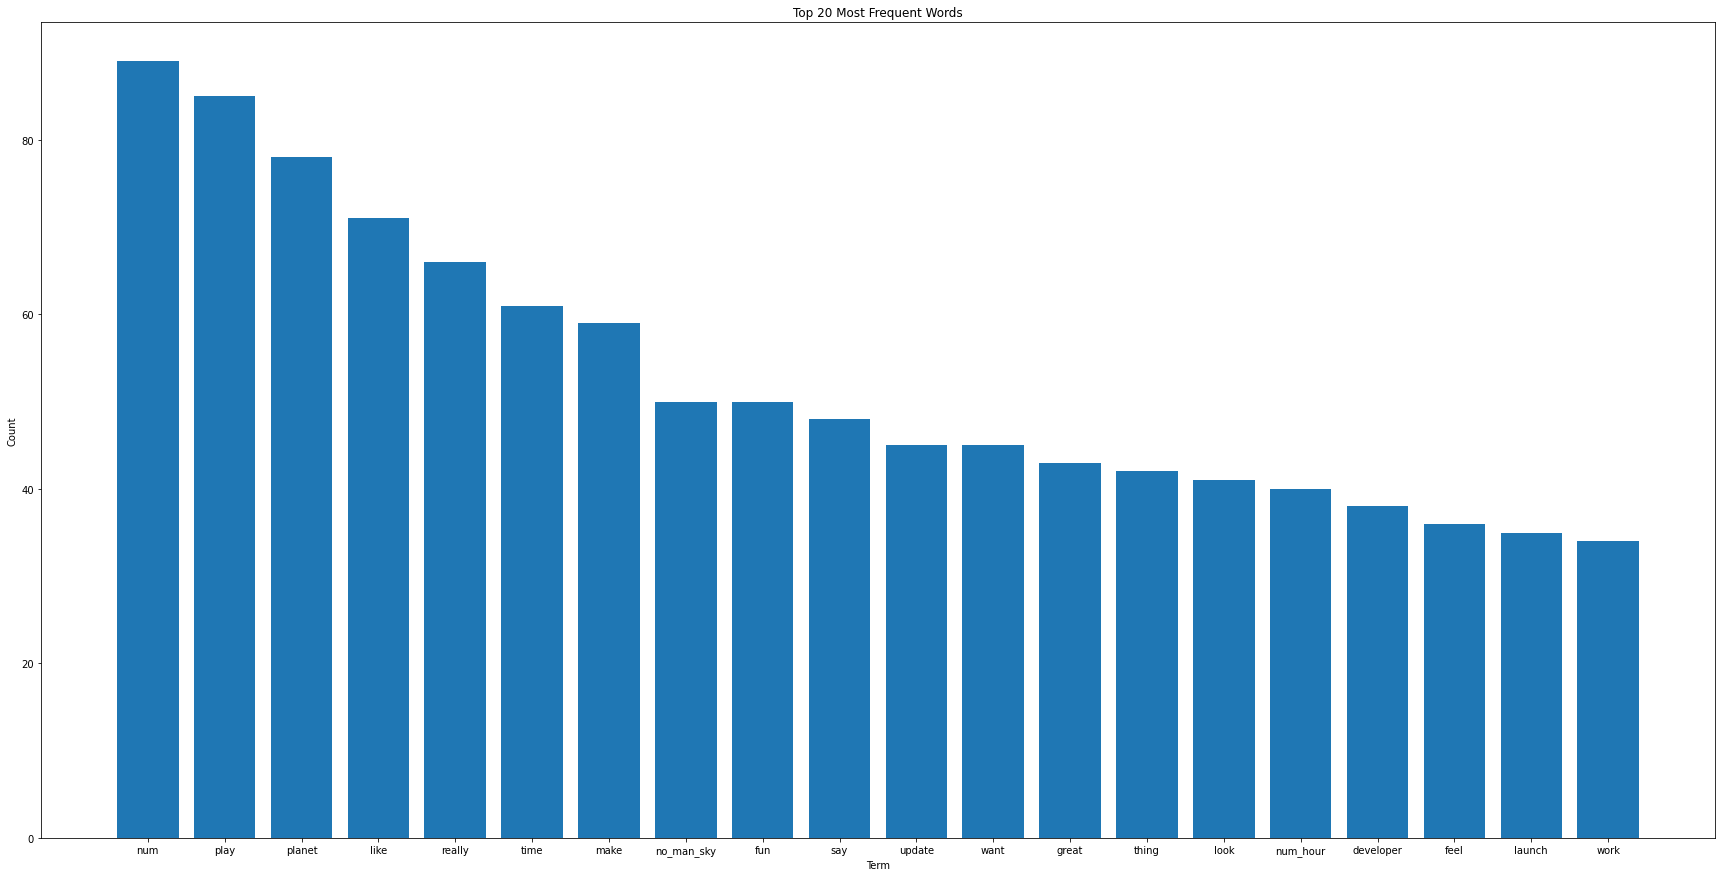

In [7]:
# get word frequencies from the bag of words and sort them by count in descending order
term_frequency = [(term, tf_matrix.sum(axis=0)[0, i]) for term, i in tf_vectorizer.vocabulary_.items()]
term_frequency = sorted(term_frequency, key = lambda x: x[1], reverse=True)
terms = [i[0] for i in term_frequency[:20]] # get top 20 words
count = [i[1] for i in term_frequency[:20]] # get counts of top 20 words

# plot the 20 most frequent words in a bar chart
fig, ax = plt.subplots(figsize=(30,15))
ax.bar(range(len(terms)), count)
ax.set_xticks(range(len(terms)))
ax.set_xticklabels(terms)
ax.set_title('Top 20 Most Frequent Words')
ax.set_xlabel('Term')
ax.set_ylabel('Count')
plt.show()

# 4. Clustering (KMeans)

In [8]:
k = 4 # number of clusters

# build and fit model, then store centroids
km = KMeans(k)
km_matrix = km.fit_transform(tfidf_matrix)
km_centroids = km.cluster_centers_.argsort()[:, ::-1]

# create a dictionary with the top three words for each cluster
top_words = {}
for i in range(4):
    top_words[i] = ""
    for c in km_centroids[i, :3]:
        if top_words[i] == "":
            top_words[i] = tfidf_words[c]
        else:
            top_words[i] = top_words[i] + ", " + tfidf_words[c]
    print('Cluster %s:' %i, top_words[i])

Cluster 0: no_man_sky, like, say
Cluster 1: num, play, really
Cluster 2: launch, update, developer
Cluster 3: planet, feel, discover


# 5. Cluster Visualization (MDS, TSNE)

C:\Users\xt17aab\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\xt17aab\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\xt17aab\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\xt17aab\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\xt17aab\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the def

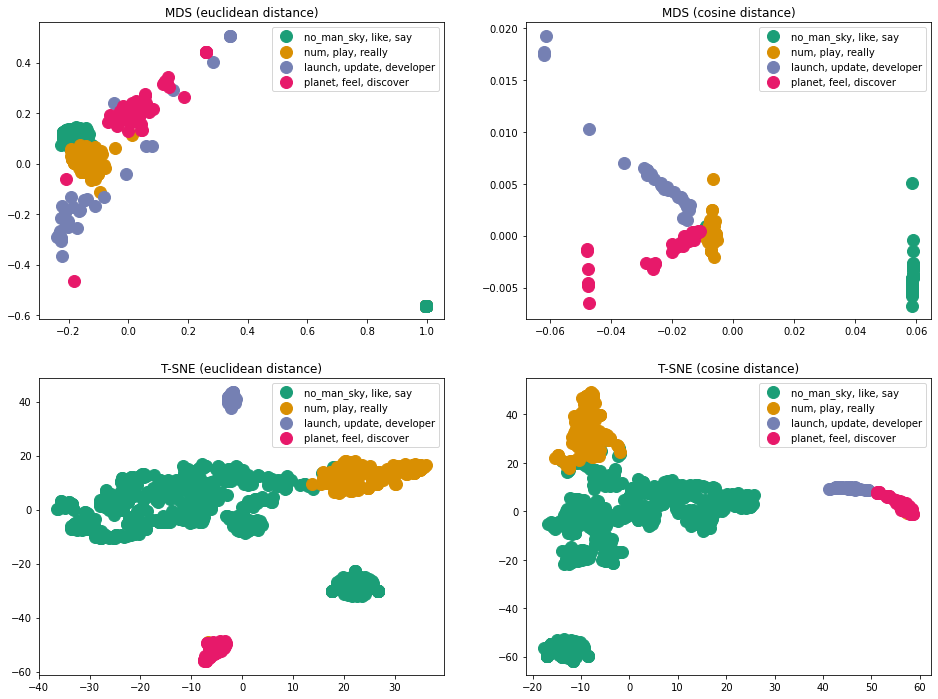

In [9]:
# fit two non-linear dimensionality reduction models
mds = MDS().fit_transform(km_matrix)
tsne = TSNE().fit_transform(km_matrix)

# fit models with cosine distance
cos_dist = 1 - cosine_similarity(km_matrix)
mds_cos = MDS(dissimilarity="precomputed").fit_transform(cos_dist)
tsne_cos = TSNE(metric="cosine").fit_transform(cos_dist)

# create data frame with coordinates, cluster labels, and post titles, grouped by clusters
df = pd.DataFrame(dict(x1=mds[:,0], y1=mds[:,1], x2=mds_cos[:,0], y2=mds_cos[:,1],
                       x3=tsne[:,0], y3=tsne[:,1], x4=tsne_cos[:,0], y4=tsne_cos[:,1],
                       label=km.labels_.tolist(), title=data['mongodb_id']))
groups = df.groupby('label')

# set a color and get the top three words for each cluster
clusters = {0: ('#1b9e77', top_words[0]),
            1: ('#d98f02', top_words[1]),
            2: ('#7580b3', top_words[2]),
            3: ('#e7196a', top_words[3]), }

# build two plots for the manifold learning models
fig, ax = plt.subplots(2,2, figsize=(16,12)) # 2x2 subplots
ax[0,0].set_title('MDS (euclidean distance)'); ax[0,1].set_title('MDS (cosine distance)') # titles for first row
ax[1,0].set_title('T-SNE (euclidean distance)'); ax[1,1].set_title('T-SNE (cosine distance)') # titles for second row
for i,g in groups: # iterate over clusters
    ax[0,0].plot(g.x1, g.y1, marker='o', linestyle='', ms=12, color=clusters[i][0], label=clusters[i][1])
    ax[0,1].plot(g.x2, g.y2, marker='o', linestyle='', ms=12, color=clusters[i][0], label=clusters[i][1])
    ax[1,0].plot(g.x3, g.y3, marker='o', linestyle='', ms=12, color=clusters[i][0], label=clusters[i][1])
    ax[1,1].plot(g.x4, g.y4, marker='o', linestyle='', ms=12, color=clusters[i][0], label=clusters[i][1])
ax[0,0].legend(); ax[0,1].legend(); ax[1,0].legend(); ax[1,1].legend() # add legends

# save the figure as png and display it
plt.savefig('clusters.png', dpi=200)
plt.show()

# 6. Cluster Exploration

In [10]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      this.fig.toolbar.draw();
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}


# define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
  font-size:14px;
  font-weight: bold;
  color: White;
  background-color: DodgerBlue;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -75px;}
"""

# create plot
fig, ax = plt.subplots(figsize=(14,6))
for i,g in groups: # layer the plot by iterating through cluster labels
    points = ax.plot(g.x3, g.y3, marker='o', linestyle='', ms=14, color=clusters[i][0], label=clusters[i][1])
    labels = [i.title() for i in g.title] # get the blog posts titles in title case
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels, voffset=10, hoffset=10, css=css) # set tooltip
    mpld3.plugins.connect(fig, tooltip, TopToolbar()) # connect tooltip to fig
ax.legend(edgecolor='white') # add 

# save as html file and show plot
html = mpld3.fig_to_html(fig)
with open("clusters.html", "w") as file: file.write(html)
mpld3.display()

# 7. Predictive Evaluation

In [11]:
# use model to predict the cluster for each title and content
title_predictions = []
content_predictions = []
for i in range(len(data['correct'])):
    titles = tfidf_vectorizer.transform([data['mongodb_id'][i]])
    title_predictions.append(km.predict(titles))
    contents = tfidf_vectorizer.transform([data['correct'][i]])
    content_predictions.append(km.predict(contents))

# check how often a post's title and content are predicted to belong to the same cluster
match = []
for i in range(len(title_predictions)):
    if title_predictions[i] == content_predictions[i]:
        match.append(1)
    else:
        match.append(0)
print('Title/content match: ' + str(round(sum(match)/len(match)*100, 1)) + '%')

# test to what extent each manually defined topic category falls into its own cluster
category_predictions = []
for topic in ('psychology cognitive science', 'willpower self improvement',
            'philosophy spirituality', 'morality ethics'):
    Category = tfidf_vectorizer.transform([topic])
    category_predictions.append(km.predict(Category)[0])  
print('Category similarity: ' + str(len(set(category_predictions))/k*100) + '%')

Title/content match: 72.3%
Category similarity: 25.0%


# 8. More Models (NMF, LSA, LDA)

In [12]:
nmf = NMF(k)
nmf_matrix = nmf.fit_transform(tfidf_matrix)

lsa = TruncatedSVD(k)
lsa_matrix = lsa.fit_transform(tfidf_matrix)

lda = LatentDirichletAllocation(k, learning_method='batch')
lda_matrix = lda.fit_transform(tf_matrix)

km_nmf = KMeans(k).fit(nmf_matrix) # NMF-based k-means
km_lsa = KMeans(k).fit(lsa_matrix) # LSA-based k-means
km_lda = KMeans(k).fit(lda_matrix) # LDA-based k-means

C:\Users\xt17aab\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


# 9. Qualitative Evaluation

In [13]:
def top_words_decomp(model_name, model, terms):
    ''' prints the top 3 words of each cluster
        from the components of decomposition models '''
    print(model_name)
    for i, topic in enumerate(model.components_):
        print("Cluster %d: " % (i), end="")
        print(" ".join([terms[t] for t in topic.argsort()[:-4:-1]]))
    print()

top_words_decomp(" ---NMF---", nmf, tfidf_words)
top_words_decomp(" ---LSA---", lsa, tfidf_words)
top_words_decomp(" ---LDA---", lda, tf_words)
    
def top_words_cluster(model_name, centers):
    ''' prints the top 3 words of each cluster
        from the centroids of the k-means models '''
    print(model_name)
    for i in range(k):
        print("Cluster %d: " % i, end="")
        print(" ".join([tfidf_words[c] for c in centers[i, :3]]))
    print()

top_words_cluster(" ---K-M---", km_centroids)
top_words_cluster(" ---NMF-KM---", nmf.inverse_transform(km_nmf.cluster_centers_).argsort()[:, ::-1])
top_words_cluster(" ---LSA-KM---", lsa.inverse_transform(km_lsa.cluster_centers_).argsort()[:, ::-1])

 ---NMF---
Cluster 0: really time no_man_sky
Cluster 1: num num_hour amaze
Cluster 2: planet feel different
Cluster 3: play like want

 ---LSA---
Cluster 0: num play like
Cluster 1: num num_hour planet
Cluster 2: planet different discover
Cluster 3: play like num_hour

 ---LDA---
Cluster 0: play no_man_sky want
Cluster 1: update launch fun
Cluster 2: planet great make
Cluster 3: num_hour good thing

 ---K-M---
Cluster 0: no_man_sky like say
Cluster 1: num play really
Cluster 2: launch update developer
Cluster 3: planet feel discover

 ---NMF-KM---
Cluster 0: num num_hour amaze
Cluster 1: really time no_man_sky
Cluster 2: planet feel different
Cluster 3: play like want

 ---LSA-KM---
Cluster 0: really no_man_sky time
Cluster 1: play like num_hour
Cluster 2: num num_hour time
Cluster 3: planet like feel



# 10. Autoencoder

In [14]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

learning_rate = 0.001
training_epochs = 501

n_input = tfidf_matrix.shape[1]
n_hidden_1 = tfidf_matrix.shape[1] // 4
n_hidden_2 = 4

X = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}

biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([n_input])),
}


def encoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    return layer_2

def decoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),biases['decoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']), biases['decoder_b2']))
    return layer_2

enc = encoder(X)
dec = decoder(enc)

cost = tf.reduce_mean(tf.pow(X - dec, 2))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

init = tf.global_variables_initializer()
sess = tf.InteractiveSession() # interactive for jupyter notebook
sess.run(init)

for epoch in range(training_epochs):
    for i in range(len(data)): # one batch per blog post
        _, c = sess.run([optimizer, cost], feed_dict={X: tfidf_matrix[i].toarray()})
    if epoch % 100 == 0: # display every hundredth epoch
        print("Epoch:", '%03d' % epoch, "cost =", "{:.9f}".format(c))

autoenc_results = dec.eval(feed_dict={X: tfidf_matrix.toarray()})      
sess.close()

Instructions for updating:
non-resource variables are not supported in the long term
Epoch: 000 cost = 0.008404304
Epoch: 100 cost = 0.006718612
Epoch: 200 cost = 0.006337219
Epoch: 300 cost = 0.006342959
Epoch: 400 cost = 0.006341815
Epoch: 500 cost = 0.006314424


C:\Users\xt17aab\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\xt17aab\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\xt17aab\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
C:\Users\xt17aab\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1

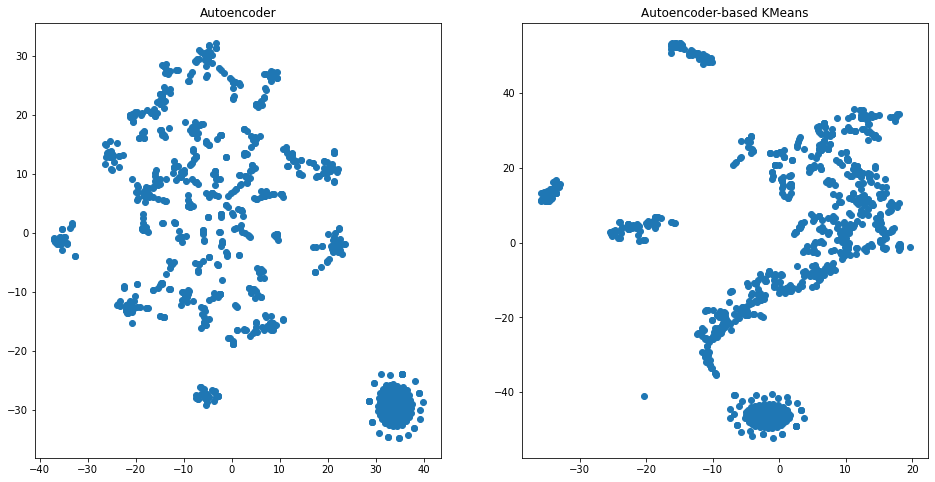

In [15]:
km_autoenc = KMeans(k).fit(autoenc_results) # autoencoder-based k-means

# fit T-SNE with cosine distance of autoencoder and autoencoder-based k-means results
cos_dist_autoenc = 1 - cosine_similarity(autoenc_results)
tsne_autoenc = TSNE(metric="cosine").fit_transform(cos_dist_autoenc)
cos_dist_km_autoenc = 1 - cosine_similarity(KMeans(k).fit_transform(autoenc_results))
tsne_km_autoenc = TSNE(metric="cosine").fit_transform(cos_dist_km_autoenc)

# plot T-SNE results
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].set_title('Autoencoder')
ax[0].scatter(tsne_autoenc[:,0], tsne_autoenc[:,1])
ax[1].set_title('Autoencoder-based KMeans')
ax[1].scatter(tsne_km_autoenc[:,0], tsne_km_autoenc[:,1])
plt.show()

# 11. Quantitative Evaluation

In [17]:
# create evaluation table
evaluation = pd.DataFrame({'Model': ['km', 'km_nmf', 'km_lsa', 'km_lda', 'km_autoenc']})
sc, wcss, chi = [], [], []

# calculate scores
for model in (km, km_nmf, km_lsa, km_lda, km_autoenc):
    sc.append(silhouette_score(tfidf_matrix.toarray(), model.labels_))
    wcss.append(round(model.inertia_, 2))
    chi.append(round(calinski_harabasz_score(tfidf_matrix.toarray(), model.labels_), 2))

# use term frequency matrix for LDA
sc[-2] = silhouette_score(tf_matrix.toarray(), km_lda.labels_)
chi[-2] = round(calinski_harabasz_score(tf_matrix.toarray(), model.labels_), 2)

# fill and display evaluation table
evaluation['Silhouette'] = sc
evaluation['WCSS'] = wcss
evaluation['Calinski-Harabasz'] = chi
evaluation.head()

,Model,Silhouette,WCSS,Calinski-Harabasz
0,km,0.066962,721.53,15.96
1,km_nmf,0.069847,4.85,17.37
2,km_lsa,0.069827,24.82,17.39
3,km_lda,0.000471,51.28,10.99
4,km_autoenc,0.064463,395.52,13.14
